In [1]:
pip install torch torch-geometric scikit-image networkx scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cell 1: Imports and Configuration
import os
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import networkx as nx
import warnings
import scipy.ndimage as ndimage

# Machine Learning
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, BatchNorm

# Image Processing
from skimage.segmentation import slic
from scipy.ndimage import uniform_filter, binary_opening
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (precision_recall_fscore_support, accuracy_score, 
                             cohen_kappa_score, balanced_accuracy_score, f1_score, matthews_corrcoef)

# --- CONFIGURATION ---
REGION_DIR = "/Users/subhamsoni/region_folder" 
WINDOW_SIZE = 3
N_SEGMENTS = 10000 
COMPACTNESS = 20
BLOCKS = (5, 5)

# Hardware Acceleration
if torch.backends.mps.is_available(): DEVICE = torch.device("mps")
elif torch.cuda.is_available(): DEVICE = torch.device("cuda")
else: DEVICE = torch.device("cpu")

# --- NEW 3-CLASS SYSTEM ---
CLASS_NAMES = ["NoDamage", "MinorDamage", "SevereDamage"] 
WATER_THRESH = 0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cell 2: Utility Functions
def read_band(path):
    if not os.path.exists(path): raise FileNotFoundError(f"{path} not found")
    with rasterio.open(path) as src:
        arr = src.read(1).astype("float32")
        if src.nodata is not None: arr[arr == src.nodata] = np.nan
        profile = src.profile.copy()
    return arr, profile

def add_spatial_context_stack(stack, window=3):
    feats = []
    for b in range(stack.shape[2]):
        band = np.nan_to_num(stack[:,:,b])
        mean = uniform_filter(band, size=window)
        mean_sq = uniform_filter(band*band, size=window)
        std = np.sqrt(np.maximum(0, mean_sq - mean*mean))
        feats.extend([band, mean, std])
    return np.stack(feats, axis=-1)

def compute_report(y_true, y_pred, class_names):
    labels_all = np.arange(len(class_names))
    oa = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    p, r, f, s = precision_recall_fscore_support(y_true, y_pred, labels=labels_all, zero_division=0)
    metrics = {
        "OA": oa, "F1_macro": f1,
        "BalancedAcc": balanced_accuracy_score(y_true, y_pred),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "MCC": matthews_corrcoef(y_true, y_pred)
    }
    df = pd.DataFrame({"class": class_names, "precision": p, "recall": r, "f1": f, "support": s})
    return df, metrics

def save_prediction_map_full(flat_pred, H, W, profile, out_path):
    arr2d = flat_pred.reshape(H, W).astype(np.uint8)
    meta = profile.copy()
    meta.update(dtype=rasterio.uint8, count=1, compress='lzw')
    with rasterio.open(out_path, 'w', **meta) as dst: dst.write(arr2d, 1)

def plot_hotspot_map(pred_map, class_names):
    # Updated Colormap for 3 Classes: Green (No), Yellow (Minor), Red (Severe)
    cmap = mcolors.ListedColormap(["green", "gold", "red"])
    norm = mcolors.BoundaryNorm(np.arange(len(class_names)+1)-0.5, cmap.N)
    plt.figure(figsize=(10,8))
    plt.imshow(pred_map, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=np.arange(len(class_names)))
    cbar.ax.set_yticklabels(class_names)
    plt.axis("off"); plt.show()

In [4]:
# Cell 3: Fast Graph Construction
class CycloneGraphBuilder:
    def __init__(self, n_segments=10000, compactness=20):
        self.n_segments = n_segments
        self.compactness = compactness
        self.gpr = GaussianProcessRegressor(
            kernel=C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.1, length_scale_bounds=(1e-2, 1e2)),
            random_state=42, alpha=1e-2
        )
        self.scaler = StandardScaler()

    def process_image(self, image_stack, labels, water_mask, d_ndvi_proxy):
        H, W, C_total = image_stack.shape
        print(f"Step 1: Segmenting Image into {self.n_segments} Superpixels...")
        img_for_slic = np.nan_to_num(image_stack[:, :, :3])
        segments = slic(img_for_slic, n_segments=self.n_segments, compactness=self.compactness, start_label=1, mask=~water_mask)
        
        unique_segments = np.unique(segments)
        if unique_segments[0] == 0: unique_segments = unique_segments[1:]
        
        print(f"Step 2: Vectorized Feature Extraction ({len(unique_segments)} Nodes)...")
        # Means & Stds
        feat_mean = np.zeros((len(unique_segments), C_total))
        feat_std = np.zeros((len(unique_segments), C_total))
        for c in range(C_total):
            feat_mean[:, c] = ndimage.mean(image_stack[:,:,c], labels=segments, index=unique_segments)
            feat_std[:, c] = ndimage.standard_deviation(image_stack[:,:,c], labels=segments, index=unique_segments)
            
        r_grid, c_grid = np.indices((H, W))
        r_mean = ndimage.mean(r_grid, labels=segments, index=unique_segments)
        c_mean = ndimage.mean(c_grid, labels=segments, index=unique_segments)
        node_centroids = np.column_stack([r_mean, c_mean])
        
        d_val = ndimage.mean(d_ndvi_proxy, labels=segments, index=unique_segments)
        # Fast Majority Vote for Labels
        node_labels = ndimage.maximum(labels, labels=segments, index=unique_segments).astype(int)
        
        valid_mask = ~np.isnan(feat_mean).any(axis=1) & np.isfinite(d_val)
        
        final_feats = np.hstack([feat_mean[valid_mask], feat_std[valid_mask]])
        final_labels = node_labels[valid_mask]
        final_centroids = node_centroids[valid_mask]
        final_d_val = d_val[valid_mask]
        
        # GPR (Fast)
        print("Step 3: Computing GPR...")
        gpr_X = final_centroids.copy()
        gpr_X[:, 0] /= H; gpr_X[:, 1] /= W
        
        noise_proxy = np.mean(feat_std[valid_mask], axis=1)**2
        if len(noise_proxy) > 0:
            noise_proxy = (noise_proxy - noise_proxy.min()) / (noise_proxy.max() - noise_proxy.min() + 1e-6) * 0.1 + 0.01
        
        if len(gpr_X) > 1000:
            idx = np.random.choice(len(gpr_X), 1000, replace=False)
            self.gpr.alpha = noise_proxy[idx]
            self.gpr.fit(gpr_X[idx], final_d_val[idx])
        else:
            self.gpr.alpha = noise_proxy
            self.gpr.fit(gpr_X, final_d_val)
            
        _, y_std = self.gpr.predict(gpr_X, return_std=True)
        
        # Topology
        print("Step 4: Building Spatial Graph (k=6)...")
        nbrs = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(final_centroids)
        _, indices = nbrs.kneighbors(final_centroids)
        src = np.repeat(np.arange(len(final_centroids)), 6)
        dst = indices[:, 1:].flatten()
        
        # Pruning
        f_src = final_feats[src]; f_dst = final_feats[dst]
        dists = np.linalg.norm(f_src - f_dst, axis=1)
        mask = dists < (dists.mean() + 0.5 * dists.std())
        src, dst = src[mask], dst[mask]
        
        edge_index = torch.tensor([np.concatenate([src, dst]), np.concatenate([dst, src])], dtype=torch.long)
        
        G = nx.Graph()
        G.add_edges_from(zip(src, dst))
        deg = dict(G.degree()); comp = list(nx.connected_components(G))
        comp_map = {n: len(c) for c in comp for n in c}
        
        topo_feats = np.column_stack([
            [deg.get(i,0) for i in range(len(final_centroids))],
            [comp_map.get(i,0) for i in range(len(final_centroids))]
        ])
        
        x_raw = np.hstack([final_feats, y_std.reshape(-1,1), topo_feats])
        print("Step 5: Standardizing...")
        x_scaled = self.scaler.fit_transform(x_raw)
        
        data = Data(x=torch.tensor(x_scaled, dtype=torch.float), y=torch.tensor(final_labels, dtype=torch.long),
                    edge_index=edge_index, pos=torch.tensor(final_centroids, dtype=torch.float))
        
        valid_seg_ids = unique_segments[valid_mask]
        mapping = {seg_id: i for i, seg_id in enumerate(valid_seg_ids)}
        
        return data, segments, mapping

In [5]:
# Cell 4: Deep Residual Model
class CycloneGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.bn3 = BatchNorm(hidden_dim)
        self.classifier = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.elu(x1)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.elu(x2)
        x2 = F.dropout(x2, p=self.dropout, training=self.training)
        x2 = x2 + x1 # Residual
        
        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(x3)
        x3 = F.elu(x3)
        x3 = F.dropout(x3, p=self.dropout, training=self.training)
        x3 = x3 + x2 # Residual
        
        out = self.classifier(x3)
        return out

--- Loading GeoTIFF Data ---
--- 1. Statistical Label Generation (Histogram Based) ---
    dNDVI Stats -> Mean: -0.236, Std: 0.038
    Thresholds -> Severe < -0.274 | Minor < -0.245
--- 2. Building Graph ---
Step 1: Segmenting Image into 10000 Superpixels...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skimage/segmentation/slic_superpixels.py:60: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  centroids, _ = kmeans2(coord[idx_dense], coord[idx], iter=5)


Step 2: Vectorized Feature Extraction (9877 Nodes)...
Step 3: Computing GPR...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Step 4: Building Spatial Graph (k=6)...
Step 5: Standardizing...

>>> Fold 1/5


/var/folders/cl/d43f4t9n0wb8kfw0dw6rj00h0000gn/T/ipykernel_5999/200361679.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  edge_index = torch.tensor([np.concatenate([src, dst]), np.concatenate([dst, src])], dtype=torch.long)


    OA: 0.785 | F1: 0.729 | Kappa: 0.561

>>> Fold 2/5
    OA: 0.831 | F1: 0.739 | Kappa: 0.610

>>> Fold 3/5
    OA: 0.753 | F1: 0.732 | Kappa: 0.592

>>> Fold 4/5
    OA: 0.824 | F1: 0.740 | Kappa: 0.633

>>> Fold 5/5
    OA: 0.792 | F1: 0.748 | Kappa: 0.641

=== Final Average ===
OA             0.797052
F1_macro       0.737785
BalancedAcc    0.774301
Kappa          0.607532
MCC            0.612511
dtype: float64


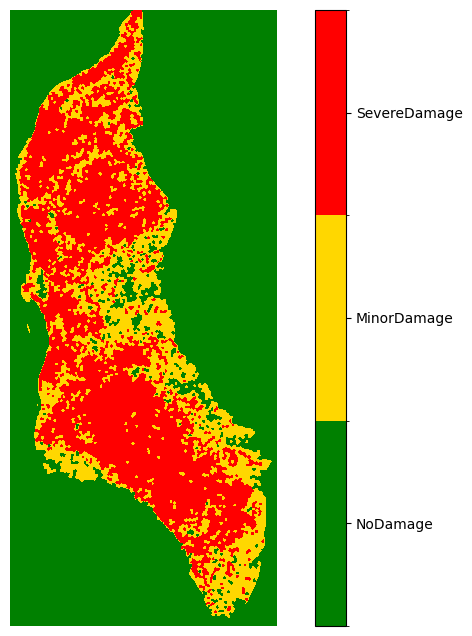

In [6]:
# Cell 5: Statistical Thresholds + Weighted Sampling
def run_gnn_pipeline():
    print("--- Loading GeoTIFF Data ---")
    try:
        ndvi_pre, src_profile = read_band(os.path.join(REGION_DIR, "NDVI_pre.tif"))
        ndvi_post, _ = read_band(os.path.join(REGION_DIR, "NDVI_post.tif"))
        d_ndvi = ndvi_post - ndvi_pre
        
        # Load other bands (Shortened for brevity but keep your full loading block!)
        ndvi_dur, _ = read_band(os.path.join(REGION_DIR, "NDVI_during.tif"))
        lai_pre, _ = read_band(os.path.join(REGION_DIR, "LAI_pre.tif"))
        lai_dur, _ = read_band(os.path.join(REGION_DIR, "LAI_during.tif"))
        lai_post, _ = read_band(os.path.join(REGION_DIR, "LAI_post.tif"))
        mvi_pre, _ = read_band(os.path.join(REGION_DIR, "MVI_pre.tif"))
        mvi_dur, _ = read_band(os.path.join(REGION_DIR, "MVI_during.tif"))
        mvi_post, _ = read_band(os.path.join(REGION_DIR, "MVI_post.tif"))
        vh_pre, _ = read_band(os.path.join(REGION_DIR, "S1_VH_pre.tif"))
        vh_dur, _ = read_band(os.path.join(REGION_DIR, "S1_VH_during.tif"))
        vh_post, _ = read_band(os.path.join(REGION_DIR, "S1_VH_post.tif"))
        vv_pre, _ = read_band(os.path.join(REGION_DIR, "S1_VV_pre.tif"))
        vv_dur, _ = read_band(os.path.join(REGION_DIR, "S1_VV_during.tif"))
        vv_post, _ = read_band(os.path.join(REGION_DIR, "S1_VV_post.tif"))
        
        base_stack = np.stack([ndvi_pre, ndvi_dur, ndvi_post, lai_pre, lai_dur, lai_post,
                               mvi_pre, mvi_dur, mvi_post, vh_pre, vh_dur, vh_post,
                               vv_pre, vv_dur, vv_post], axis=-1)
    except Exception as e: print(e); return

    print("--- 1. Statistical Label Generation (Histogram Based) ---")
    H, W = ndvi_pre.shape
    water_mask = binary_opening((np.isnan(ndvi_pre) | (ndvi_pre <= WATER_THRESH)), structure=np.ones((3,3)))
    
    # NEW: Statistical Thresholds (Mean - k*Std)
    valid_dndvi = d_ndvi[np.isfinite(d_ndvi) & ~water_mask]
    mu = np.mean(valid_dndvi)
    std = np.std(valid_dndvi)
    print(f"    dNDVI Stats -> Mean: {mu:.3f}, Std: {std:.3f}")
    
    # Define 3 Classes based on Z-scores
    t_severe = mu - 1.0 * std   # Drop > 1 std dev
    t_minor = mu - 0.25 * std   # Drop > 0.25 std dev
    
    print(f"    Thresholds -> Severe < {t_severe:.3f} | Minor < {t_minor:.3f}")
    
    labels = np.full((H,W), 255, dtype=np.uint8)
    mask = np.isfinite(d_ndvi) & ~water_mask
    
    # Class 2: Severe (Deepest drop)
    labels[mask & (d_ndvi <= t_severe)] = 2
    # Class 1: Minor (Moderate drop)
    labels[mask & (d_ndvi > t_severe) & (d_ndvi <= t_minor)] = 1
    # Class 0: No Damage (Stable or increasing)
    labels[mask & (d_ndvi > t_minor)] = 0
    labels[water_mask] = 0 # Ensure water is background (or handle as Class 0)

    print("--- 2. Building Graph ---")
    feats_stack = add_spatial_context_stack(base_stack, window=WINDOW_SIZE)
    builder = CycloneGraphBuilder(n_segments=N_SEGMENTS, compactness=COMPACTNESS)
    data, segments, mapping = builder.process_image(feats_stack, labels, water_mask, d_ndvi)
    
    # Blocks
    pos = data.pos.numpy()
    row_h, col_w = H/BLOCKS[0], W/BLOCKS[1]
    block_ids = (pos[:,0]//row_h * BLOCKS[1] + pos[:,1]//col_w).astype(int)
    
    # Train
    all_metrics = []
    final_preds = np.full(len(pos), 255, dtype=np.uint8)
    input_dim = data.x.shape[1]
    
    # 5-Fold Grouped CV
    for fold in range(5): 
        print(f"\n>>> Fold {fold+1}/5")
        test_mask = torch.tensor((block_ids // BLOCKS[1]) == fold, dtype=torch.bool)
        train_mask = ~test_mask
        valid_tr_mask = train_mask & (data.y != 255)
        valid_te_mask = test_mask & (data.y != 255)
        
        if valid_te_mask.sum() == 0: continue
        
        # --- NEW: Weighted Random Sampler ---
        train_indices = torch.where(valid_tr_mask)[0]
        train_labels = data.y[train_indices].cpu().numpy()
        
        # Calculate weights for each sample based on class frequency
        class_counts = np.bincount(train_labels)
        class_weights = 1. / (class_counts + 1e-5)
        sample_weights = torch.tensor([class_weights[t] for t in train_labels], dtype=torch.float)
        
        # Create Sampler
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
        # Batch size can be large since we just want to sample indices
        train_loader = DataLoader(train_indices, batch_size=1024, sampler=sampler)
        
        # Model
        model = CycloneGNN(input_dim, 256, 3).to(DEVICE) # Output Dim = 3
        opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        crit = CrossEntropyLoss() # Weights handled by sampler now
        
        d_gpu = data.clone().to(DEVICE)
        model.train()
        
        for epoch in range(100): # 100 Epochs is enough with oversampling
            for batch_idx in train_loader:
                opt.zero_grad()
                # Forward pass whole graph (standard for small graphs)
                out = model(d_gpu)
                # Loss ONLY on the sampled (balanced) batch
                loss = crit(out[batch_idx], d_gpu.y[batch_idx])
                loss.backward()
                opt.step()
            
        model.eval()
        with torch.no_grad():
            out = model(d_gpu).argmax(dim=1).cpu().numpy()
            final_preds[valid_te_mask.cpu().numpy()] = out[valid_te_mask.cpu().numpy()]
            _, met = compute_report(data.y[valid_te_mask].cpu().numpy(), out[valid_te_mask.cpu().numpy()], CLASS_NAMES)
            print(f"    OA: {met['OA']:.3f} | F1: {met['F1_macro']:.3f} | Kappa: {met['Kappa']:.3f}")
            all_metrics.append(met)

    print("\n=== Final Average ===")
    print(pd.DataFrame(all_metrics).mean())
    
    # Reconstruct
    pmap = np.full((H,W), 255, dtype=np.uint8)
    inv_map = {v:k for k,v in mapping.items()}
    for i, pred_val in enumerate(final_preds):
        if pred_val != 255: pmap[segments == inv_map[i]] = pred_val
    pmap[water_mask] = 0
    
    save_path = os.path.join(REGION_DIR, "gnn_final_3class.tif")
    save_prediction_map_full(pmap.flatten(), H, W, src_profile, save_path)
    plot_hotspot_map(pmap, CLASS_NAMES)

if __name__ == "__main__":
    run_gnn_pipeline()